In [1]:
from IPython.core.display import HTML
css_file = '../../../msc/custom.css'
HTML(open(css_file, "r").read())

Modelling Carrer Choices
========================

The model is based on the following research paper:

    Derek Neal (1999). The Complexity of Job Mobility among Young Men, Journal of Labor Economics, 17(2), 237-261.
    
The implementation draws heavily from the material provided on the *Quantitative Economics* website.

### Model Features

Individuals choose their career and job within a career to max- imize the expected discounted value of lifetime wages. They solve an infinite horizon dynamic programming problem with two state variables.

### Objective

$$\mathrm{E}\sum\limits _{i=1}^{n}\beta^{t}\omega_{t}$$

### Payoffs

$$w_t = \theta_t + \epsilon_t$$

where:
* $\theta_t$ contribution of current occupation at time t
* $\epsilon_t$ contribution of current job at time t

### Decision Problem

At the start of time t, a worker has the following options:
* **Stay Put**, retain a current (career, job) pair $(\theta_t,\epsilon_t)$
* **New Job**, retain a current career $\theta_t$ but redraw a job $\epsilon_t$ 
* **New Life**, redraw both a career $\theta_t$ and a job $\epsilon_t$

Draws of $\theta$ and $\epsilon$ are independent of each other and past values, with $\theta_t \sim F$ and $\epsilon_t \sim G$.

### Value Functions

$$ V_{SP} = \theta+\varepsilon+\beta V(\theta,\varepsilon) \\
V_{NJ} = \theta+\int\varepsilon'G(d\varepsilon')+\beta\int V(\theta,\varepsilon')G(d\varepsilon') \\
V_{NL} = \int\theta'F(d\theta')+\int\varepsilon'G(d\varepsilon')+\beta\int\int V(\theta',\varepsilon')G(d\varepsilon')F(d\theta') $$

### Course Registration

Please register for our class ECON41904 by sending an eMail to Brett Baker at: bbaker@uchicago.edu

Housekeeping
------------

In [1]:
%matplotlib inline

Load Resources
--------------

In [2]:
# libraries
import scipy
import numpy as np
    
# project library
from support import *

Parametrization
---------------

In [3]:
# Initialize container
para = dict()

# Preferences
para['beta'] = 0.95  # Time preference

# Distribution Grid
para['B'] = 5.0      # Upper bound for both epsilon and theta
para['N'] = 50       # Number of possible realizations for both epsilon and theta

# Parametrization of Career Distribution
para['F_a'], para['F_b'] = 1.0, 1.0
para['G_a'], para['G_b'] = 1.0, 1.0


Derived Attributes
----------

In [4]:
# Initialize container
attr = dict()

# Grid of random variables
attr['theta']   = np.linspace(0, para['B'], para['N'])
attr['epsilon'] = np.linspace(0, para['B'], para['N'])

# Construct probabilities
attr['F_probs'] = BetaBinomial_pdf(para['N'] - 1, para['F_a'], para['F_b']) 
attr['G_probs'] = BetaBinomial_pdf(para['N'] - 1, para['G_a'], para['G_b'])

# Construct means.
attr['F_mean'] = np.sum(attr['theta'] * attr['F_probs'])
attr['G_mean'] = np.sum(attr['epsilon'] * attr['G_probs'])

Auxiliary Functions
-------------------

In [5]:
def evaluate_alternative(which, para, attr, v, i, j):
    ''' Evaluate alternatives
    '''
    
    if which == 'Stay Put':
        
        eval_ = attr['theta'][i] + attr['epsilon'][j] + para['beta'] * v[i,j]
        
    elif which == 'New Job': 
        
        eval_ = attr['theta'][i] + attr['G_mean'] + para['beta'] * np.dot(v[i,:], attr['G_probs'])
        
    elif which == 'New Life':
        
        eval_ = attr['G_mean'] + attr['F_mean'] + para['beta'] * np.dot(attr['F_probs'], np.dot(v, attr['G_probs']))
        
    else:
        
        raise AssertionError('Alternative misspecified.')
        
    # Finishing 
    return eval_
    
def get_greedy(v, para, attr):
    ''' Compute optimal actions taking v as the value function
    '''
    # Initialize container
    policy = np.empty(v.shape, dtype = int)

    # Evalaute cases
    for i in range(para['N']):
        
        for j in range(para['N']):
            
            values = [] 
            
            for which in ['Stay Put', 'New Job', 'New Life']:
                             
                values += [evaluate_alternative(which, para, attr, v, i, j)]
      
            # Determine optimal policy
            policy[i,j] = np.argmax(values) + 1
            
    # Finishing 
    return policy

def bellman_operator(v, para, attr):
    ''' The Bellman operator for the model.
    '''
    
    # Initialize container
    new_v = np.empty(v.shape, dtype = float)
    
    # Evalaute cases
    for i in range(para['N']):

        for j in range(para['N']):

            values = [] 
            
            for which in ['Stay Put', 'New Job', 'New Life']:
                             
                values += [evaluate_alternative(which, para, attr, v, i, j)]
                
            new_v[i,j] = np.amax(values)
    
    # Finishing 
    return new_v

def compute_fixed_point(T, v, para, attr, error_tol = 1e-3, max_iter = 50):
    ''' Compute the fixed point.
    '''
    # Initialization
    error = error_tol + 1
    
    iterate = 0

    while True:
        
        new_v = T(v, para, attr)
        
        iterate += 1
        
        error = np.max(np.abs(new_v - v))

        v = new_v
        
        # Terminal conditions
        if iterate > max_iter: break
            
        if error < error_tol: break
    
    # Finishing
    return v

Solving the Model
-----------------

In [6]:
# Starting value
v_init =  np.ones((para['N'],para['N']))*100

# Determine fix point 
v = compute_fixed_point(bellman_operator, v_init, para, attr)

# Determine optimal policy
optimal_policy = get_greedy(v, para, attr)

Analysis
--------

### Plot the Optimal Policy

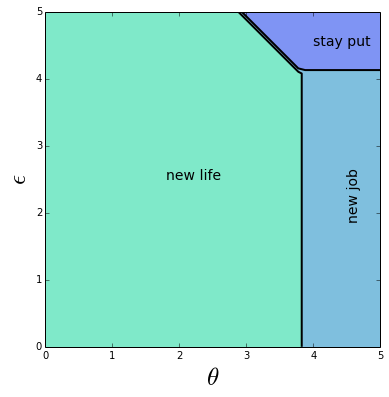

In [7]:
plot_optimal_policy(optimal_policy, attr)